In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".50"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"


import tinygp
import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)

In [33]:
class LatentKernel(tinygp.kernels.Kernel):
    """A custom kernel based on Rajpaul et al. (2015)

    Args:
        kernel: The kernel function describing the latent process. This can be any other
            ``tinygp`` kernel.
        coeff_prim: The primal coefficients for each class. This can be thought of as how
            much the latent process itself projects into the observations for that class.
            This should be an array with an entry for each class of observation.
        coeff_deriv: The derivative coefficients for each class. This should have the same
            shape as ``coeff_prim``.
    """

    kernel: tinygp.kernels.Kernel
    coeff_prim: jax.Array
    coeff_deriv: jax.Array

    def __init__(self, kernel, coeff_prim, coeff_deriv):
        self.kernel = kernel
        self.coeff_prim, self.coeff_deriv = jnp.broadcast_arrays(
            jnp.asarray(coeff_prim), jnp.asarray(coeff_deriv)
        )

    def evaluate(self, X1, X2):
        t1, label1 = X1
        t2, label2 = X2

        # Differentiate the kernel function: the first derivative wrt x1
        Kp = jax.grad(self.kernel.evaluate, argnums=0)

        # ... and the second derivative
        Kpp = jax.grad(Kp, argnums=1)

        # Evaluate the kernel matrix and all of its relevant derivatives
        K = self.kernel.evaluate(t1, t2)
        d2K_dx1dx2 = Kpp(t1, t2)

        # For stationary kernels, these are related just by a minus sign, but we'll
        # evaluate them both separately for generality's sake
        dK_dx2 = jax.grad(self.kernel.evaluate, argnums=1)(t1, t2)
        dK_dx1 = Kp(t1, t2)

        # Extract the coefficients
        a1 = self.coeff_prim[label1]
        a2 = self.coeff_prim[label2]
        b1 = self.coeff_deriv[label1]
        b2 = self.coeff_deriv[label2]

        # Construct the matrix element
        return a1 * a2 * K + a1 * b2 * dK_dx2 + b1 * a2 * dK_dx1 + b1 * b2 * d2K_dx1dx2

In [34]:
base_kernel = tinygp.kernels.ExpSquared(scale=1.5) * tinygp.kernels.ExpSineSquared(
    scale=2.5, gamma=0.5
)
kernel = LatentKernel(base_kernel, [1.0, 0.5], [-0.1, 0.3])

random = np.random.default_rng(5678)
t1 = np.sort(random.uniform(0, 10, 200))
label1 = np.zeros_like(t1, dtype=int)
t2 = np.sort(random.uniform(0, 10, 300))
label2 = np.ones_like(t2, dtype=int)
X = (np.append(t1, t2), np.append(label1, label2))

gp = tinygp.GaussianProcess(kernel, X, diag=1e-5)
y = gp.sample(jax.random.PRNGKey(1234))

subset = np.append(
    random.integers(len(t1), size=50),
    len(t1) + random.integers(len(t2), size=15),
)
X_obs = (X[0][subset], X[1][subset])
y_obs = y[subset] + 0.1 * random.normal(size=len(subset))

offset = 2.5

plt.axhline(0.5 * offset, color="k", lw=1)
plt.axhline(-0.5 * offset, color="k", lw=1)

plt.plot(t1, y[: len(t1)] + 0.5 * offset, label="class 0")
plt.plot(t2, y[len(t1) :] - 0.5 * offset, label="class 1")

plt.plot(X_obs[0], y_obs + offset * (0.5 - X_obs[1]), ".k", label="measured")

plt.xlim(0, 10)
plt.ylim(-1.1 * offset, 1.1 * offset)
plt.xlabel("t")
plt.ylabel("y + offset")
_ = plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")

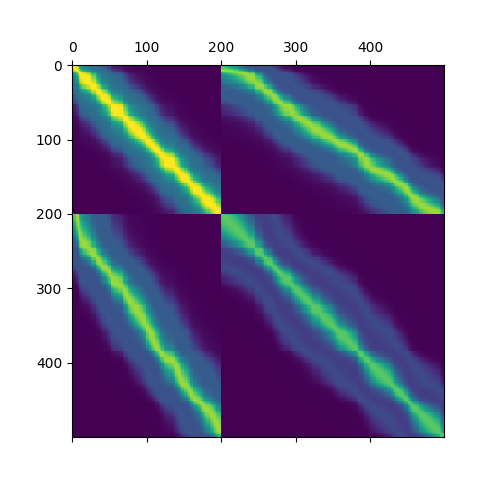

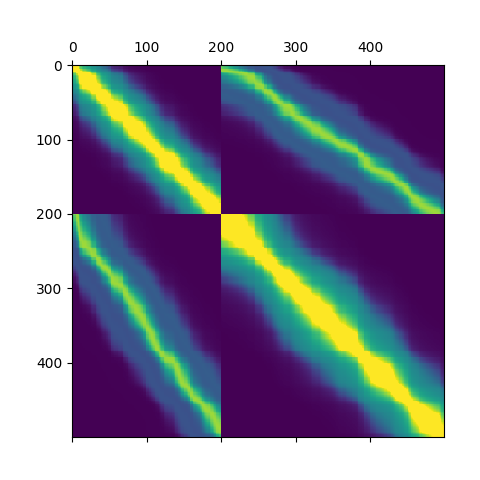

In [37]:
class MultiLatentKernel(tinygp.kernels.Kernel):
    """A custom kernel based on Rajpaul et al. (2015)

    Args:
        kernel: The kernel function describing the latent process. This can be any other
            ``tinygp`` kernel.
        coeff_prim: The primal coefficients for each class. This can be thought of as how
            much the latent process itself projects into the observations for that class.
            This should be an array with an entry for each class of observation.
        coeff_deriv: The derivative coefficients for each class. This should have the same
            shape as ``coeff_prim``.
    """

    kernel_multi: tinygp.kernels.Kernel
    kernel_trained: tinygp.kernels.Kernel
    coeff_prim: jax.Array
    coeff_deriv: jax.Array
    coeff_trained: jax.Array

    def __init__(self, kernel_multi, kernel_trained, coeff_prim, coeff_deriv, coeff_trained):
        self.kernel_multi = kernel_multi
        self.kernel_trained = kernel_trained
        self.coeff_prim, self.coeff_deriv, self.coeff_trained = jnp.broadcast_arrays(
            jnp.asarray(coeff_prim), jnp.asarray(coeff_deriv), jnp.asarray(coeff_trained)
        )

    def evaluate(self, X1, X2):
        t1, label1 = X1
        t2, label2 = X2

        # Differentiate the kernel function: the first derivative wrt x1
        Kp = jax.grad(self.kernel_multi.evaluate, argnums=0)

        # ... and the second derivative
        Kpp = jax.grad(Kp, argnums=1)

        # Evaluate the kernel matrix and all of its relevant derivatives
        K0 = self.kernel_multi.evaluate(t1, t2)
        d2K_dx1dx2 = Kpp(t1, t2)

        K1 = self.kernel_trained.evaluate(t1, t2)
        ones = jnp.where(label1 != label2, 0., 1.)        
        
        # For stationary kernels, these are related just by a minus sign, but we'll
        # evaluate them both separately for generality's sake
        dK_dx2 = jax.grad(self.kernel_multi.evaluate, argnums=1)(t1, t2)
        dK_dx1 = Kp(t1, t2)

        # Extract the coefficients
        a1 = self.coeff_prim[label1]
        a2 = self.coeff_prim[label2]
        b1 = self.coeff_deriv[label1]
        b2 = self.coeff_deriv[label2]
        c1 = self.coeff_trained[label1]
        c2 = self.coeff_trained[label2]

        K = a1 * a2 * K0 + c1 * c2 * K1 * ones
        
        
        return  K + a1 * b2 * dK_dx2 + b1 * a2 * dK_dx1 + b1 * b2 * d2K_dx1dx2


multi_kernel = tinygp.kernels.ExpSquared(scale=1.5) * tinygp.kernels.ExpSineSquared(
    scale=2.5, gamma=0.5
)
trained_kernel =  tinygp.kernels.ExpSquared(scale=1.5)

oldK_matrix = LatentKernel(multi_kernel, [1.0, 0.75], [-0.1, 0.3])(X, X)
plt.matshow(oldK_matrix, vmin=0.0, vmax=1.0)

newK_matrix = MultiLatentKernel(multi_kernel, trained_kernel, [1.0, 0.75], [-0.1, 0.3], [-0.5, 0.75])(X, X)
plt.matshow(newK_matrix, vmin=0.0, vmax=1.0)




299


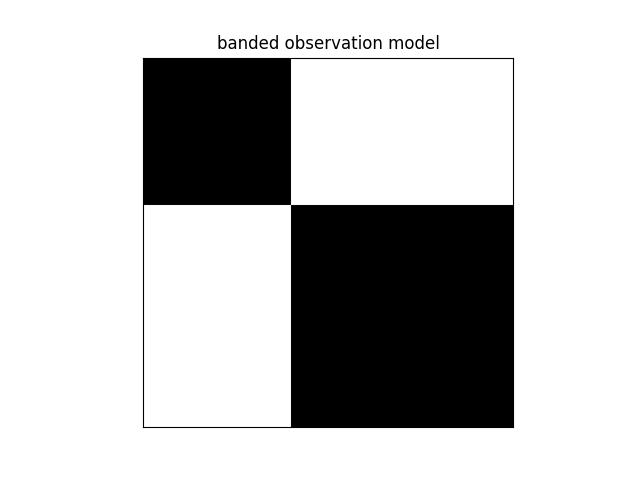

In [18]:
tt, calib_id = X

from collections import Counter
bandwidth = max(Counter(calib_id).values()) - 1
print(bandwidth)

nt = len(tt)
off_diags = np.zeros((nt, bandwidth))

caliberr = np.ones(nt)

for j in range(bandwidth):
    m = calib_id[: nt - j - 1] == calib_id[j + 1 :]
    off_diags[: nt - j - 1, j][m] = caliberr[calib_id[: nt - j - 1][m]]
plt.figure()
plt.imshow(off_diags)

noise_model = tinygp.noise.Banded(diag=caliberr, off_diags=off_diags)

plt.imshow(noise_model @ np.eye(nt), cmap="gray_r")
plt.xticks([])
plt.yticks([])
_ = plt.title("banded observation model")

In [13]:
def _indices( -> tuple[tuple[JAXArray, JAXArray], tuple[JAXArray, JAXArray]]:
    N, J = jnp.shape(self.off_diags)
    sparse_idx_1 = []
    sparse_idx_2 = []
    dense_idx_1 = []
    dense_idx_2 = []
    for j in range(J):
        sparse_idx_1.append(np.arange(N - j - 1))
        sparse_idx_2.append(np.full(N - j - 1, j, dtype=int))
        dense_idx_1.append(np.arange(0, N - j - 1))
        dense_idx_2.append(np.arange(j + 1, N))

    return (
        (np.concatenate(sparse_idx_1), np.concatenate(sparse_idx_2)),
        (np.concatenate(dense_idx_1), np.concatenate(dense_idx_2)),
    )




299
